This notebook will focus on feature engineering for numeric features. We observed in the exploratory notebook that there are numeric variables that capture both socioeconomic and non-socioeconomic characteristics of customers and that strong correlations exist between the socioeconomic variables.

We'll proceed with feature engineering for numeric features as follows:

1. Normal transformations for age, campaign variables
2. Evaluate outcomes for previous variable
2. Remove outliers for age, campaign, cons.conf.idx, cons.price.idx, emp.var.rate, previous variables
3. Feature selection for socioeconomic variables

In [1]:
%load_ext autoreload
%autoreload 2

from utils import code

In [65]:
import pandas as pd
import numpy as np
import scikitplot as skplt

from support.datasets import get_data
from support.experiments import experiment_1, experiment_4, get_auc_scorer, display_model_performance
from support.evaluation import plot_learning_curve, evaluate_model
from support.model import Model, TunedModel

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [5]:
X_train, y_train = get_data('../data/train.csv')
X_test, y_test = get_data('../data/test.csv')
X_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,25,blue-collar,single,high.school,no,yes,no,cellular,jul,mon,619,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
1,40,admin.,married,high.school,no,no,no,telephone,jun,thu,97,1,999,0,nonexistent,1.4,94.465,-41.8,4.958,5228.1
2,51,technician,married,university.degree,no,yes,no,cellular,aug,wed,512,5,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1
3,37,blue-collar,married,high.school,unknown,yes,no,cellular,jul,tue,423,1,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1
4,54,housemaid,married,university.degree,unknown,yes,no,cellular,aug,thu,297,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1


In [62]:
scorer = get_auc_scorer()

## Normal Transformations

Apply transformations to age, campaign, previous to make them more normal

In [7]:
X_train_norm = X_train.copy()

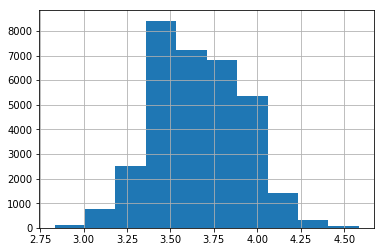

In [10]:
np.log(X_train_norm['age']).hist();

In [11]:
X_train_norm['age'] = np.log(X_train_norm['age'])

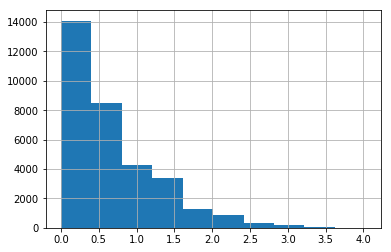

In [12]:
np.log(X_train_norm['campaign']).hist();

In [11]:
X_train_norm['campaign'] = np.log(X_train_norm['campaign'])

In [42]:
def evaluate_models(X, y, pipeline):
  results = []
  
  # Decision tree
  print("Training decision tree")
  param_grid = [{
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [1, 50, 100],
    'dt__min_samples_leaf': [5, 10]
  }]
  result = evaluate_model(X, y, 'dt', DecisionTreeClassifier(), param_grid, scorer, pipeline)
  results.append(result)

  #  Logistic regression
  print("Training logistic regression")
  param_grid = [{
    'lr__C': [.001, .01, 1., 3.],
    'lr__penalty': ['l1', 'l2']
  }]
  result = evaluate_model(X, y, 'lr', LogisticRegression(), param_grid, scorer, pipeline)
  results.append(result)
  
  # NN
  print("Training neural net")
  param_grid = [{
    'nn__hidden_layer_sizes': [(10), (100), (200)],
  #   'nn__activation': ['logistic', 'tanh', 'relu'],
  #   'nn__solver': ['lbfgs']
  }]
  result = evaluate_model(X, y, 'nn', MLPClassifier(), param_grid, scorer, pipeline)
  results.append(result)
  
  return results

### Baseline Model (Pre-Transform)

In [45]:
cat_pipeline = experiment_4.get_categorical_pipeline()
num_pipeline = experiment_1.get_numeric_pipeline(['age', 'campaign'])
union = FeatureUnion([
  ('cat', cat_pipeline),
  ('num', num_pipeline)
])
pipeline = Pipeline([('union', union)])

In [46]:
results = evaluate_models(X_train, y_train, pipeline)

Training decision tree
==> Starting 5-fold cross validation for dt model, 32950 examples
==> Elapsed seconds: 19.254
Best dt model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Best dt score: 0.629
Training logistic regression
==> Starting 5-fold cross validation for lr model, 32950 examples


/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


==> Elapsed seconds: 25.591
Best lr model: LogisticRegression(C=3.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Best lr score: 0.605
Training neural net
==> Starting 5-fold cross validation for nn model, 32950 examples
==> Elapsed seconds: 270.214
Best nn model: MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=200, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
Best nn score: 0.628


/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Normal Model (Post-Transform)

In [47]:
results = evaluate_models(X_train_norm, y_train, pipeline)

Training decision tree
==> Starting 5-fold cross validation for dt model, 32950 examples
==> Elapsed seconds: 16.930
Best dt model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Best dt score: 0.631
Training logistic regression
==> Starting 5-fold cross validation for lr model, 32950 examples


/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


==> Elapsed seconds: 30.992
Best lr model: LogisticRegression(C=3.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Best lr score: 0.605
Training neural net
==> Starting 5-fold cross validation for nn model, 32950 examples
==> Elapsed seconds: 249.453
Best nn model: MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=100, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
Best nn score: 0.632


/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


There was a noticable impact on both the decision tree and neural net models with a normal transform so we'll use it going forward.

## Previous Variable Transformation

There are a lot of instances with a `previous` value of 0. How are campaign results distributed with respect to `previous` values of 0 and not 0?

In [52]:
previous = X_train['previous'].apply(lambda x: 1 if x != 0 else 0)
y_previous = pd.concat([previous, y_train], axis=1)
y_previous.groupby('previous').size() / len(y_previous)

previous
0    0.864188
1    0.135812
dtype: float64

In [54]:
y_previous.groupby(['previous', 'y']).size() / y_previous.groupby('previous').size()

previous  y
0         0    0.911501
          1    0.088499
1         0    0.733631
          1    0.266369
dtype: float64

### Impact on existing model

In [69]:
# Create the indicator
X_train_previous = X_train.copy()
X_train_previous['previous'] = X_train_previous['previous'].apply(lambda x: 1 if x != 0 else 0)

X_test_previous = X_test.copy()
X_test_previous['previous'] = X_test_previous['previous'].apply(lambda x: 1 if x != 0 else 0)

# Create previous pipeline
previous_ct = ColumnTransformer([('previous', OneHotEncoder(), ['previous'])])

# Create a feature union to add pdays
previous_pipeline = FeatureUnion([
  ('cat', cat_pipeline), 
  ('previous_pipeline', previous_ct)])

# Reload the model and train it with the previous variable
# Load the model
tuned_model = Model.load('../models/experiment-1-model.pkl')
nb_model = Model(tuned_model.name, tuned_model.model, previous_pipeline)

# Train it
nb_model.train(X_train_previous, y_train)

# Score it
nb_model.score(X_test_previous, y_test, scorer)

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.6741352776074343

In [74]:
display_model_performance(nb_model, X_test_previous, y_test)

Number of targeted customers: 543
0.6741352776074343
Model profit: $286,983
Model lift over basline profit: 1.3 or $59,565
Targeted conversion rate: 0.50
Conversion rate lift over baseline: 1.26

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       274
         1.0       0.50      1.00      0.66       269

   micro avg       0.50      0.50      0.50       543
   macro avg       0.25      0.50      0.33       543
weighted avg       0.25      0.50      0.33       543



/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Outlier Removal

Remove outliers for age, campaign, cons.conf.idx, cons.price.idx, emp.var.rate, previous variables

In [ ]:
X_train_norm[['age', 'campaign', 'cons.conf.idx', 'emp.var.rate', 'previous']]